In [3]:
import os
import pandas as pd
import numpy as np
from collections import Counter
from PIL import Image

meta_dir = "data/meta"
train_img_dir = "data/train/img"
test_img_dir = "data/test/img"

train_df = pd.read_csv(os.path.join(meta_dir, "train.csv"))
test_df = pd.read_csv(os.path.join(meta_dir, "test.csv"))

print(train_df['label'].value_counts(normalize=True))
print(test_df['label'].value_counts(normalize=True))

label
0    0.894466
1    0.105534
Name: proportion, dtype: float64
label
0    0.890438
1    0.109562
Name: proportion, dtype: float64


In [4]:
def analyze_images(img_dir, df):
    shapes = []
    for fname in df['filename'].head(10):
        img_path = os.path.join(img_dir, fname)
        img = Image.open(img_path)
        shapes.append(np.array(img).shape)
    shape_counts = Counter(shapes)
    return shape_counts

print(analyze_images(train_img_dir, train_df))
print(analyze_images(test_img_dir, test_df))

sample_img = Image.open(os.path.join(train_img_dir, train_df['filename'].iloc[0]))
arr = np.array(sample_img)
print(arr.min(), arr.max())

Counter({(642, 227, 3): 1, (649, 222, 3): 1, (624, 229, 3): 1, (630, 229, 3): 1, (643, 228, 3): 1, (639, 229, 3): 1, (640, 230, 3): 1, (641, 230, 3): 1, (632, 232, 3): 1, (643, 231, 3): 1})
Counter({(644, 231, 3): 1, (632, 233, 3): 1, (628, 226, 3): 1, (643, 229, 3): 1, (629, 230, 3): 1, (638, 223, 3): 1, (641, 231, 3): 1, (637, 230, 3): 1, (637, 227, 3): 1, (636, 230, 3): 1})
10 175


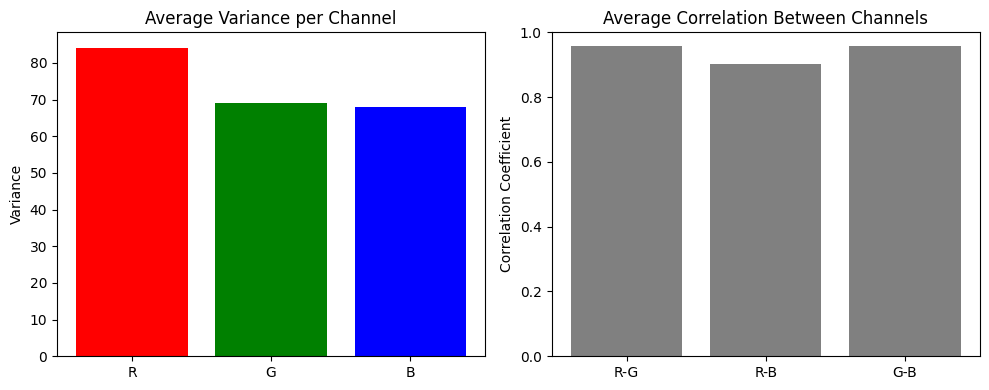

Average variance per channel (R, G, B): [84.15682934 69.14708229 67.87569047]
Average correlation between channels (R-G, R-B, G-B): [0.95692645 0.90361602 0.95829388]


In [9]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

img_dir = "data/train/img"
sample_images = [os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.lower().endswith(".png")][:50]

variances = []
correlations = []

for img_path in sample_images:
    img = cv2.imread(img_path)
    if img is None:
        continue
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # 채널별 분산
    var_r = np.var(img_rgb[:, :, 0])
    var_g = np.var(img_rgb[:, :, 1])
    var_b = np.var(img_rgb[:, :, 2])
    variances.append([var_r, var_g, var_b])
    
    # 채널 간 상관계수 계산 (분산이 0이면 1로 처리)
    def safe_corr(a, b):
        if np.std(a) == 0 or np.std(b) == 0:
            return 1.0
        return np.corrcoef(a, b)[0, 1]
    
    r = img_rgb[:, :, 0].flatten()
    g = img_rgb[:, :, 1].flatten()
    b = img_rgb[:, :, 2].flatten()
    
    corr_rg = safe_corr(r, g)
    corr_rb = safe_corr(r, b)
    corr_gb = safe_corr(g, b)
    
    correlations.append([corr_rg, corr_rb, corr_gb])

variances_mean = np.mean(variances, axis=0)
correlations_mean = np.mean(correlations, axis=0)

# 시각화
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].bar(['R', 'G', 'B'], variances_mean, color=['red', 'green', 'blue'])
axs[0].set_title('Average Variance per Channel')
axs[0].set_ylabel('Variance')

axs[1].bar(['R-G', 'R-B', 'G-B'], correlations_mean, color='gray')
axs[1].set_title('Average Correlation Between Channels')
axs[1].set_ylabel('Correlation Coefficient')
axs[1].set_ylim(0, 1)

plt.tight_layout()
plt.show()

print("Average variance per channel (R, G, B):", variances_mean)
print("Average correlation between channels (R-G, R-B, G-B):", correlations_mean)


### 채널 간 분산 차이가 크지 않음.
### 채널 상관계수 모든 값이 0.9이상임. 보통 이러면 채널 각 픽셀 패턴이 거의 동일함.
### RGB가 거의 중복된 정보를 포함하므로, 밝기정보가 핵심임